# <center>  Multi Class Classification - Cancer Diagnosis

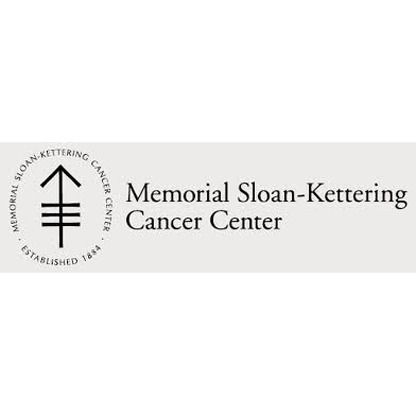

In [1]:
# MSKCC Image
from IPython.display import Image
Image(filename='Memorial Sloan.jpg',width=750)

## Table of Contents:

      1. Introduction
      2. Objective
      3. Data Description
      4. Exploratory Data Analysis
      5. Univariate analysis
      6. Machine learning models
      7. Summary & Conclusion

### 1. Introduction 

- This dataset is provided by Memorial Sloan Kettering Cancer Center (MSKCC). This dataset was a part of Neural Information      Processing System (NIPS) 2017.
  We are given sequence of thousands of genetic mutation (Mutations are small changes in the gene that can corrupt the genetic    code). Considering this information we have to classify the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 
  
  Currently this interpretation of gene is done MANUALLY. This is very time consuming task where a PATHOLOGIST has to manually review and classify every single genetic mutation based on evidence from text based clinical literature. 
  

- Actual Workflow :  https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

### 2. Objective

- Our objective is to AUTOMATE the classifications of mutations based on evidence from text based clinical literature.


- Few key observations : Given this dataset i have made few key observations.
 
 1) No low latency requirement : Given an input we need not provide the class label within very short span of time (like few seconds or minutes). We can take reasonable time to provide an output. 
 
 2) Interpretability of the model : We are dealing with critical dataset, we need to make sure our models are interpretable. We need to understand why we have classified a datapoint to a certain class label. 
 
 3) Probability of a datapoint belonging to a certain class label is necessary : Providing a probability value for each class label is very much needed, it gives cancer specialist/doctor to confidently take a decision.




### 3. Data Description


#### 3.1 Data Overview
- Source of data : https://www.kaggle.com/c/msk-redefining-cancer-treatment/data


- We have two data sets :

   1) Training_variants : This dataset has 4 columns, & 3321 rows. It contains ID,Gene code,type of variation and class labels [1-9].

   2) Training_text : This dataset has 2 columns & 3321 rows. It contains ID,clinical evidence(text) , that pathologists use to classify mutations.


- PLEASE NOTE: We are not given which class labels has Cancer or not. (https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198543)

##### Example of a Training_text datapoint

- ID,Text 0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a....

#### 3.2 Problem Overview

- We have a multiclass classification problem to solve for [class 1-9]


- The performance metric used in this problem are : 
      
      - Multi class log-loss
      - Confusion Matrix
      
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

      
#### Train, CV & Test data

- We split the data randomly as follows :
  Train - 64%, CV - 16% & Test - 20%.





In [2]:
# Reading training_variants data

import pandas as pd
training_variants = pd.read_csv(r"C:\Users\AVINASH\Desktop\AAIC\Portfolio\Memorial Sloan Cancer Detection\Memorial Sloan\training_variants")
# Gives number of row count
print('Number of data points : ', training_variants.shape[0])
# Gives number of column count
print('Number of columns : ', training_variants.shape[1])
print('Features/Columns : ', training_variants.columns.values)
training_variants.head()

Number of data points :  3321
Number of columns :  4
Features/Columns :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# Reading training_text data 
# separator is two vertical lines, so we use sep="\|\|".
import warnings
warnings.filterwarnings("ignore")

training_text = pd.read_csv(r"C:\Users\AVINASH\Desktop\AAIC\Portfolio\Memorial Sloan Cancer Detection\Memorial Sloan\training_text",
                            sep="\|\|",names=["ID","TEXT"],skiprows = 1)
# Gives number of row count
print('Number of data points : ', training_text.shape[0])
# Gives number of column count
print('Number of columns : ', training_text.shape[1])
print('Features/Columns : ', training_text.columns.values)
training_text.head()

Number of data points :  3321
Number of columns :  2
Features/Columns :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# Importing libraries
import pandas as pd
import re
import time
import warnings
from scipy.sparse import hstack
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable


### 4. Exploratory Data Analysis

#### 4.1 Preprocessing of text

In [5]:
# First we will remove stopwords.
# Stopwords are commonly used words like 'a','the','an', etc...We would not want these words taking up 
# space in our database, or taking up valuable processing time.So we remove stopwords.

# loading stopwords from nltk library
stop_words = set(stopwords.words('english'))

# Defining a function to pre-process the text - I have passed three parameters : text, index & column
def nlp(final_text,index,column):
    # If the type of the final_text is not an integer then:
    if type(final_text) is not int:
        # Creating an empty string 
        string = ""
        # replace every special character with space using re.sub()
        # The sub() function replaces the matches with the text of your choice
        final_text = re.sub('[^a-zA-Z0-9\n]', ' ', final_text)
        # replace multiple spaces with single space
        final_text = re.sub('\s+',' ', final_text)
        # converting all the chars into lower-case.
        final_text = final_text.lower()
        # Splitting the final_text using split function
        for word in final_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        training_text[column][index] = string

In [6]:
# We will be using the above defined function to process the text data. 
start_time = time.clock()
# To iterate over pandas dataframe we use iterrows(). 
for index, row in training_text.iterrows():
    if type(row['TEXT']) is str:
        #Calling the function
        nlp(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time taken for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time taken for preprocessing the text : 570.2572638090561 seconds


In [7]:
# Printing the first five rows of pre-processed data.
training_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
# Merging both training_variant and training_text based on ID column
# We will be doing a inner join.
final_data = pd.merge(training_variants,training_text,on='ID', how='inner')
print(final_data.shape[0])
final_data.head()

3321


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
# Finding missing values.
# any() function returns True if any item in an iterable are true, otherwise it returns False.
# Axis 0 will act on all the ROWS in each COLUMN
# Axis 1 will act on all the COLUMNS in each ROW

final_data[final_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
# Handling missing rows. Since we don't have the text data for missing rows i have added both 
# gene column data and variation data for those missing rows. 
# We use loc[] method to extract that particular row from the dataframe
# Here we are extracting the location index in TEXT column for missing rows,and we are replacing the 
# missing rows with gene column data & variation column data for those missing rows.
final_data.loc[final_data['TEXT'].isnull(),'TEXT'] = final_data['Gene'] +' '+final_data['Variation']

# Replacing the missing rows
print(final_data[final_data['ID']==1109])
print(final_data[final_data['ID']==1277])
print(final_data[final_data['ID']==1407])
print(final_data[final_data['ID']==1639])
print(final_data[final_data['ID']==2755])

        ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F
        ID    Gene             Variation  Class                         TEXT
1277  1277  ARID5B  Truncating Mutations      1  ARID5B Truncating Mutations
        ID   Gene Variation  Class         TEXT
1407  1407  FGFR3     K508M      6  FGFR3 K508M
        ID  Gene      Variation  Class                TEXT
1639  1639  FLT1  Amplification      6  FLT1 Amplification
        ID  Gene Variation  Class        TEXT
2755  2755  BRAF     G596C      7  BRAF G596C


In [11]:
# Rechecking if any missing rows are present.
final_data[final_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [12]:
# Pre-processing of gene & variation column. 
# We are replacing multiple spaces with an underscore.
# We are using str.replace() to replace.
final_data.Gene      = final_data.Gene.str.replace('\s+', '_')
final_data.Variation = final_data.Variation.str.replace('\s+', '_')

final_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


####  4.2 Train,Cross validation & Test data split



In [13]:
# We are creating a variable called y_true to be later used while splitting the data
y_true = final_data['Class'].values
print(y_true)

# We will be randomly splitting the data in 64:16:20 ratio.
from sklearn.model_selection import train_test_split

# Split the data into test and train by maintaining same distribution of output variable 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(final_data, y_true, stratify=y_true, test_size=0.2)

# Split the train data into train and cross validation by maintaining same distribution of output variable 
#'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

# The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the 
# proportion of values provided to parameter stratify.

# For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 
# 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

[1 2 2 ... 1 4 4]


In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 4.3 Distribution of class labels

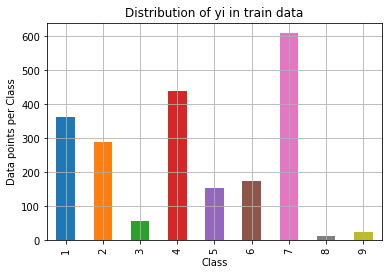

Number of data points in class 7 : 609 ( 28.67 %)
Number of data points in class 4 : 439 ( 20.67 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.61 %)
Number of data points in class 6 : 176 ( 8.29 %)
Number of data points in class 5 : 155 ( 7.3 %)
Number of data points in class 3 : 57 ( 2.68 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.56 %)
--------------------------------------------------------------------------------


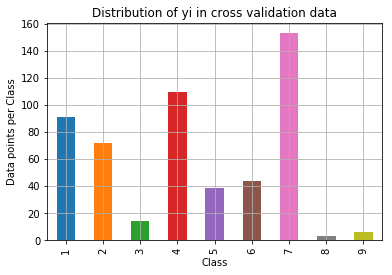

Number of data points in class 7 : 153 ( 28.76 %)
Number of data points in class 4 : 110 ( 20.68 %)
Number of data points in class 1 : 91 ( 17.11 %)
Number of data points in class 2 : 72 ( 13.53 %)
Number of data points in class 6 : 44 ( 8.27 %)
Number of data points in class 5 : 39 ( 7.33 %)
Number of data points in class 3 : 14 ( 2.63 %)
Number of data points in class 9 : 6 ( 1.13 %)
Number of data points in class 8 : 3 ( 0.56 %)
--------------------------------------------------------------------------------


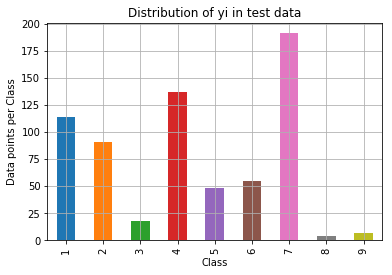

Number of data points in class 7 : 191 ( 28.72 %)
Number of data points in class 4 : 137 ( 20.6 %)
Number of data points in class 1 : 114 ( 17.14 %)
Number of data points in class 2 : 91 ( 13.68 %)
Number of data points in class 6 : 55 ( 8.27 %)
Number of data points in class 5 : 48 ( 7.22 %)
Number of data points in class 3 : 18 ( 2.71 %)
Number of data points in class 9 : 7 ( 1.05 %)
Number of data points in class 8 : 4 ( 0.6 %)


In [15]:
# Distribution of class labels
% matplotlib inline
import matplotlib.pyplot as plt

# TRAIN CLASS DISTRIBUTION
# It returns a dict, keys as class labels and values as the number of data points in that class
# value_counts() - it returns the counts of data points per class in descending order.
# sortlevel() - it sorts the index
train_class_distribution = train_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc' # Plotting each bar in different colors Red,Blue,Green etc
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# Argsort returns the indices that would sort an array.
#(-train_class_distribution.values): the minus sign will give us in decreasing order
import numpy as np
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1,':',train_class_distribution.values[i],
          '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 2), '%)')

    
# CROSS VALIDATION CLASS DISTRIBUTION
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1,':',cv_class_distribution.values[i],
          '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 2), '%)')

# TEST CLASS DISTRIBUTION
test_class_distribution = test_df['Class'].value_counts().sortlevel()

print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1,':',test_class_distribution.values[i],
          '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 2), '%)')    

# Key observations:
# 1) Across all three datasets class [7,4] are dominant classes, and class [9,8] are minority classes.
#    We can say that data is imbalanced. All classes does not occur frequently.

# 2) The distribution of yi's are very similar across all three datasets. 

#### 4.4 Random Model Classifier

- Since we use multi class log-loss as one of our performance metric, it is a good idea to build a random model classifier and 
  observe the log-loss it takes.
  
- We have 9 classes in this problem, we will generate 9 class probabilites such that they sum upto 1.

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(actual_y, predict_y):
    # C is a 9*9 confusion matrix, y axis will have actual yi's & x axis will have predicted yi's
    C = confusion_matrix(actual_y, predict_y)
    
    # To get Recall Matrix
    A =(((C.T)/(C.sum(axis=1))).T)
    # Divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two dimensional array
    # C.sum(axis =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    
    # To get Precision Matrix
    # sum of column elements = 1
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that column
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresponds to columns and axis=1 corresponds to rows in two dimensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing Confusion matrix (C) in heatmap format
    print("-"*30, "Confusion matrix", "-"*30)
    plt.figure(figsize=(20,7))
    # annot parameter returns data value in each cell.
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    
    # representing Precision matrix (B) in heatmap format
    print("-"*30, "Precision matrix (Columm Sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    
    # representing Recall matrix (A) in heatmap format
    print("-"*30, "Recall matrix (Row sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4842923524539517
Log loss on Test Data using Random Model 2.4983446179878577
------------------------------ Confusion matrix ------------------------------


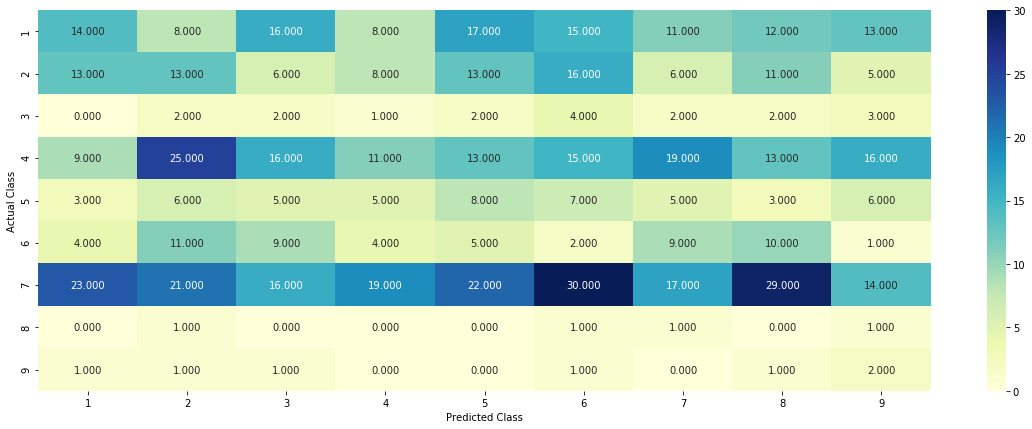

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


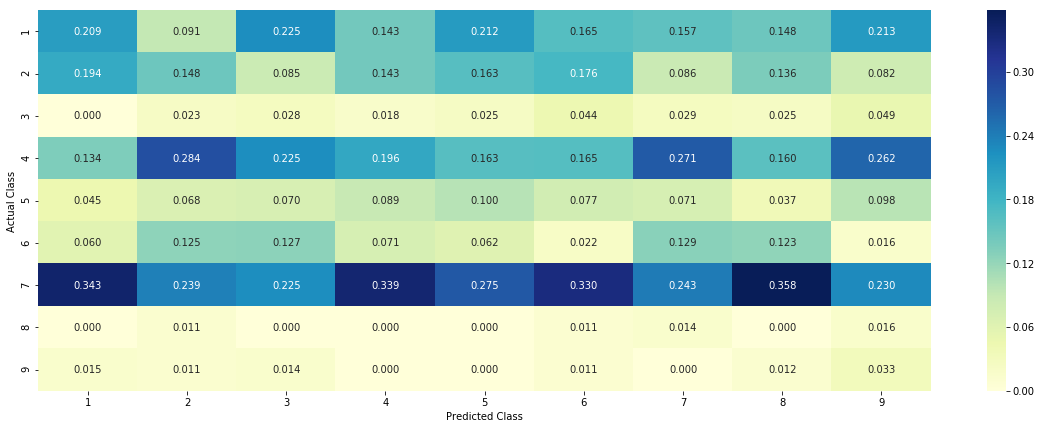

------------------------------ Recall matrix (Row sum=1) ------------------------------


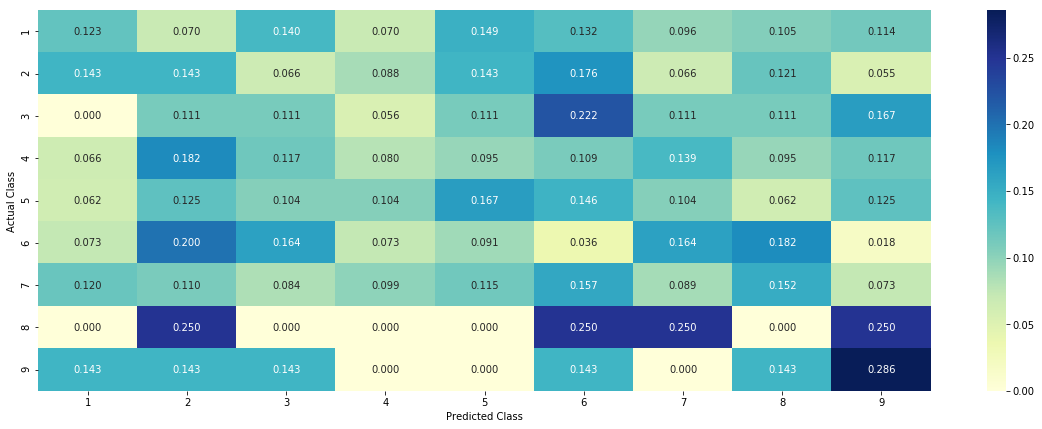

In [17]:
# We need to generate 9 numbers and the sum of numbers should be 1.
# One solution is to genarate 9 numbers and divide each of the numbers by their sum.

cv_data_len = cv_df.shape[0] # length is 532
test_data_len = test_df.shape[0] # Length is 665

# Cross validation set error
# Creating a numpy array of size (532,9). 9 because we have 9 class labels.
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    # We generate random values for all 9 classes across all data points (in this case it's 532 datapoints)
    rand_probs = np.random.rand(1,9)
    # We calculate the probabilities.
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    # When calculating log loss using the predicted input values of 0 and 1 are undefined. To avoid this problem, 
    # log loss functions typically adjust the predicted probabilities (p) by a small value (epsilon).
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

# Test-Set error.
# Creating a numpy array of size (665,9). 9 because we have 9 class labels.
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    # We generate random values for all 9 classes across all data points (in this case it's 532 datapoints)
    rand_probs = np.random.rand(1,9)
    # We calculate the probabilities.
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    # When calculating log loss using the predicted input values of 0 and 1 are undefined. To avoid this problem, 
    # log loss functions typically adjust the predicted probabilities (p) by a small value (epsilon).
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

# argmax() returns indices of the maximum values along an axis.
predicted_y =np.argmax(test_predicted_y, axis=1)
#print(predicted_y)

# We add 1 to predicted_y because argmax returns values from 0-8 (indices), but we have 9 classes [1-9].
plot_confusion_matrix(y_test, predicted_y+1)

# The log-loss for a random model on CV data & Test data are 2.48 & 2.5 respectively. So any sensible model that 
# we build should have a log loss less than 2.5

# Confusion Matrix
# Ideally the diagonal elements of a confusion matrix should have large values to show that we have built a decent model.
# If we look at our confusion matrix, for eg. We have 23 points that actually belong to class 7, but predicted as class 1
# So in line with our expectation random model does not predict the actual values correctly.

# Precision matrix (TP/TP+FP)
# The values in the diagonal cell should have been close to 1(i.e in case of a sensible model).
# Let's consider a value from 1st col, 7th row : value is 0.343
# Here it means that Of all the points that we have predicted to be of class 1, 34.3% of the points are actually belonging
# to class 7.

# Recall Matrix (TP/TP+FN)
# Let's consider a value from 2nd col, 8th row : value is 0.25
# Here it means that Of all the points that belong to class 9, of them 25% of the points are predicted to be of class 7.
# This shows how random our model is. 

### 5. Univariate Analysis


#### 5.1 Univariate analysis on gene feature

##### Gene is a categorical variable

##### Q. How many categories are there in gene variable and how are they distributed?
- Ans. There are 232 unique genes in our train data

In [18]:
# To get number of unique values from gene variable we use value_counts function
# value_counts function returns a series containing counts of unique values.
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 232
BRCA1     175
TP53      103
EGFR       84
PTEN       77
BRCA2      76
KIT        63
BRAF       62
ERBB2      51
ALK        47
CDKN2A     37
Name: Gene, dtype: int64


In [19]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 232 different categories of genes in the train data, and they are distibuted as follows


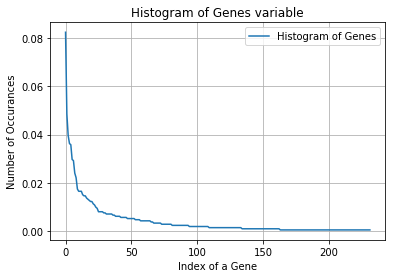

In [20]:
# Histogram of Gene variable
s = sum(unique_genes.values) # 2124 rows
h = unique_genes.values/s; # (178/2124,103/2124 and so on....)
plt.title("Histogram of Genes variable")
plt.plot(h,label = "Histogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

# Observations: a) We have a very skewed distribution. b) Very few genes occur frequently.

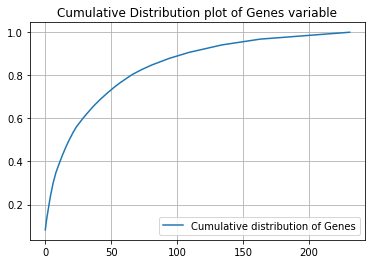

In [21]:
# Cumulative distribution plot of genes variable
c = np.cumsum(h)
plt.title("Cumulative Distribution plot of Genes variable")
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

# When we look at our CDF, we can say that top 50 genes contribute to 75% (approx) of data.

##### Q. How to featurize the gene variable.
We can featurize it using two ways:
- a) One-hot encoding
- b) Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression,Linear SVM 
while response coding is better for Naive Bayes,Random Forests.

In [22]:
# Vectorizing genes variable using tf-idf vectorizer.
gene_vectorizer = TfidfVectorizer(stop_words = 'english') 
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [23]:
train_df['Gene'].head()

1235      PIM1
3297     RUNX1
1664      FLT3
683     CDKN2A
700     CDKN2B
Name: Gene, dtype: object

In [24]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atr',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh

In [25]:
print("train_gene_feature_onehotCoding is converted feature using tf-idf method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using tf-idf method. The shape of gene feature: (2124, 231)


##### How good is gene variable predicting y_i's?

- I am going to build a model with 'gene' feature alone. We will build using logistic regression with one-hot encoded features.
The log-loss should be less than 2.5 which we observed while building a random model.

For values of alpha =  1e-05 The log loss is: 1.3553853933636526
For values of alpha =  0.0001 The log loss is: 1.1938816148198046
For values of alpha =  0.001 The log loss is: 1.2330432957837414
For values of alpha =  0.01 The log loss is: 1.4706086998318826
For values of alpha =  0.1 The log loss is: 1.7466730559863703
For values of alpha =  1 The log loss is: 1.8302599806231041


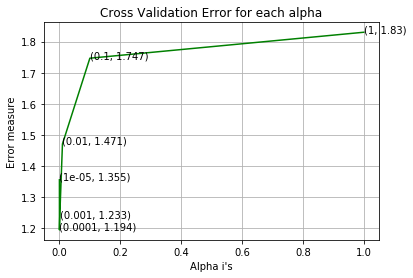

For values of best alpha =  0.0001 The train log loss is: 1.0637803422822603
For values of best alpha =  0.0001 The cross validation log loss is: 1.1947536426863299
For values of best alpha =  0.0001 The test log loss is: 1.2037823802822687


In [26]:
# Hyperparam for SGD classifier.
# SGD is a general purpose classifier, we can use any loss function here depending upon what model we build.
# For eg: For logistic-regression we can use log-loss, for SVM classifier we can use hinge loss and so on..
alpha = [10 ** x for x in range(-5, 1)] 

cv_log_error_array=[] # Empty list created. At each iteration it will be updated with log-loss values.
for i in alpha:
    # SGD updates weights one sample at a time. Since the dataset is small we can use SGD classifier.
    # Tried l1,l2 & elasticnet - All produced same results. Hence choose elasticnet.
    clf = SGDClassifier(alpha=i, penalty='elasticnet', loss='log', random_state=42)
    # Fit linear model with Stochastic Gradient Descent.
    clf.fit(train_gene_feature_onehotCoding, y_train)
    # We use calibratedClassifierCV to get probability values.
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    # Predicted yi's - Returns the probability of the sample for each class in the model
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    # Appending to the list of cv_log_error_array
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

# Plotting the log-loss
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
# Enumerate() function takes a collection of tuple & returns an enumerate object. In our case 
# it returns index value & log loss value. Eg: (0 1.40),(1 1.21) and so on..
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# It returns the index of the array with minimum loss value. In our case index is 1.
best_alpha = np.argmin(cv_log_error_array)
# Taking this alpha we fit the model. Here alpha is used to avoid overfitting.
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

# We print the log-loss for all three datasets.
predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Q. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?
Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [27]:
print("How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

# isin(function) - Whether each element in the DataFrame is contained in values
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0] # 643
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0] # 506

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100) # 96.7%
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100) # 95.1%

print("\nAs we can see 96% of the genes of test data also appear in TRAIN data.")
print("Similarly 97% of the genes of cv data also appear in TRAIN data.")
print("So gene feature appears to be stable across all dataset.")

How many data points in Test and CV datasets are covered by the  232  genes in train dataset?
Ans
1. In test data 643 out of 665 : 96.69172932330827
2. In cross validation data 517 out of  532 : 97.18045112781954

As we can see 96% of the genes of test data also appear in TRAIN data.
Similarly 95% of the genes of cv data also appear in TRAIN data.
So gene feature appears to be stable across all dataset.


#### 5.2 Univariate analysis on variation feature

##### Variation is a categorical variable

##### Q. How many categories are there in variation variable and how are they distributed?
- A. There are 1931 different categories of variations in the train data

In [28]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1928
Truncating_Mutations    55
Amplification           48
Deletion                45
Fusions                 25
Overexpression           5
Q61R                     3
Q61H                     2
T73I                     2
G13V                     2
G12D                     2
Name: Variation, dtype: int64


In [29]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1928 different categories of variations in the train data, and they are distibuted as follows


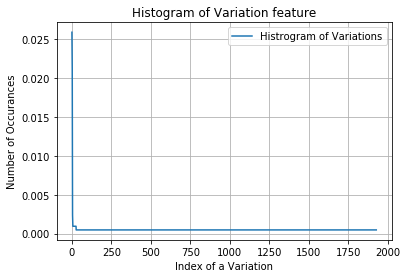

In [30]:
# Histogram of variation feature

s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.title("Histogram of Variation feature")
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

# Observations: a) This histogram look much more skewed than for gene feature. b) Only very few variations occur frequently.

[0.02589454 0.04849341 0.06967985 ... 0.99905838 0.99952919 1.        ]


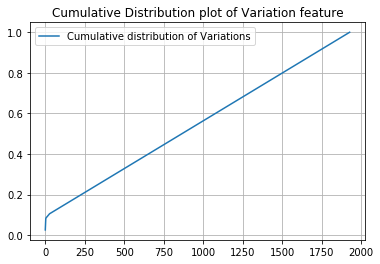

In [31]:
# Cumulative distribution plot of genes variable

c = np.cumsum(h)
print(c)
plt.title("Cumulative Distribution plot of Variation feature")
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

# As we can see 80% of our data cover almost 1500 variations, which means most of our variations have 
# occured only twice or thrice.

##### Q. How to featurize the variation feature.
We can featurize it using two ways:
- a) One-hot encoding
- b) Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression,Linear SVM 
while response coding is better for Naive Bayes,Random Forests.

In [32]:
# Vectorizing variation feature using tf-idf method.

variation_vectorizer = TfidfVectorizer(stop_words = 'english')
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [33]:
print("train_variation_feature_onehot Encoded is converted feature using the tf-idf method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehot Encoded is converted feature using the tf-idf method. The shape of Variation feature: (2124, 1957)


##### How good is variation feature predicting y_i's?

- I am going to build a model with 'variation' feature alone. We will build using logistic regression with one-hot encoded features.The log-loss should be less than 2.5 which we observed while building a random model.

For values of alpha =  1e-05 The log loss is: 1.7103865631423125
For values of alpha =  0.0001 The log loss is: 1.7052345949907866
For values of alpha =  0.001 The log loss is: 1.7073972912075384
For values of alpha =  0.01 The log loss is: 1.7179874587657065
For values of alpha =  0.1 The log loss is: 1.7237055647226258
For values of alpha =  1 The log loss is: 1.7263750644476783


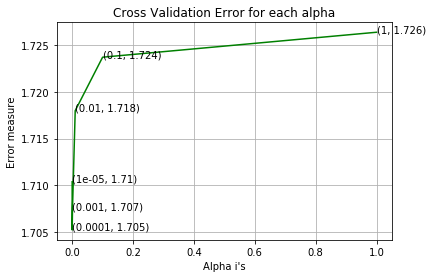

For values of best alpha =  0.0001 The train log loss is: 0.7735863062315638
For values of best alpha =  0.0001 The cross validation log loss is: 1.7052345949907866
For values of best alpha =  0.0001 The test log loss is: 1.7093840893127985


In [34]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Q. Is the variation feature stable across all the data sets (Test, Train, Cross validation)?
Ans. No, it is not.

In [35]:
print("How many data points are covered by total ", unique_variations.shape[0], " variations in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

print("\nAs we can see only 9% of the variation feature of test data appears in TRAIN data.")
print("Similarly only 11% of the variation feature of cv data appears in TRAIN data.")
print("So variation feature is not stable across all formats of data.")

How many data points are covered by total  1928  variations in test and cross validation data sets?
Ans
1. In test data 61 out of 665 : 9.172932330827068
2. In cross validation data 59 out of  532 : 11.090225563909774

As we can see only 12% of the variation feature of test data appears in TRAIN data.
Similarly only 9% of the variation feature of cv data appears in TRAIN data.
So variation feature is not stable across all formats of data.


#### 5.3 Univariate analysis on text feature

##### Text variable is basically sequence of words.

In [36]:
# We are creating this function & passing a parameter called cls_text. cls_text is a dataframe. We will be using 
# TEXT feature for this function. We iterate over every row & split the words. We create a dict out of those words
# and increment its count whenever we see that word. 
# Basically this function returns frequency of occurance of word.
def extract_dictionary_paddle(cls_text):    
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

# A defaultdict works exactly like a normal dict, but it is initialized with a function (“default factory”) 
# that takes no arguments and provides the default value for a nonexistent key.A defaultdict will never 
# raise a KeyError. Any key that does not exist gets the value returned by the default factory.
#Eg : Assume we have a list like this:- email = 'spam spam ham spam spam spam ham spam'.split()
#ham_spam_count = defaultdict(int)
#for mail in email:
#    ham_spam_count[mail] += 1
# ham_spam_count will return - defaultdict(int, {'ham': 2, 'spam': 6})

##### Text data is featurized using td-idf vectorizer.

In [37]:
# Building a tf-idf Vectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(stop_words = 'english',min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT']) # 2124*54011

# getting all the feature names (words)
# Eg of features : '00','000','0000'
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0). A1 will sum every row and returns (1*number of features) vector
# A1 - Return self as a flattened ndarray.
# Eg: a = np.matrix([[ 0,  1,  2,  3],[ 4,  5,  6,  7],[ 8,  9, 10, 11]])
# a.sum(axis=0).A1 will return : array([12, 15, 18, 21])
# Eg of train_text_fea_counts : 8.80378009855968,9.025315838575349,0.03703981110041089......
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured. 
# Eg: Suppose if we have words and its occurance like a = [1,2,3] & b = [apple,mango,orange]
# apple appearing once, mango twice and so on...
# then dict(zip(list(a),b)) will return {1: 'one', 2: 'two', 3: 'three'}
# Eg: text_fea_dict = {'00': 8.80378009855968,'000': 9.025315838575349,'0000': 0.03703981110041089}
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53181


In [38]:
# Empty list is created.
dict_list = []

# dict_list = [] contains 9 dictonaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10)/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [39]:
# Normalizing the vector
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [40]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

# Number of words for a given frequency.
# print(Counter(sorted_text_occur))

For values of alpha =  1e-05 The log loss is: 1.370221991994585
For values of alpha =  0.0001 The log loss is: 1.3201631370527007
For values of alpha =  0.001 The log loss is: 1.179903307739582
For values of alpha =  0.01 The log loss is: 1.2868045974365845
For values of alpha =  0.1 The log loss is: 1.366392403122321
For values of alpha =  1 The log loss is: 1.5322934337748437


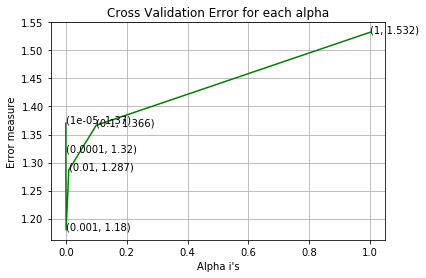

For values of best alpha =  0.001 The train log loss is: 0.6943853421378484
For values of best alpha =  0.001 The cross validation log loss is: 1.179903307739582
For values of best alpha =  0.001 The test log loss is: 1.1331684784357807


In [41]:
# Train a Logistic regression+ Calibration model using text features which are one-hot encoded using tf-idf 
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Q. Is the text feature stable across all the data sets (Test, Train, Cross validation)?
Ans. Yes it is.

In [42]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(stop_words = 'english',min_df = 3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [43]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.766 % of word of test data appeared in train data
98.439 % of word of Cross Validation appeared in train data


##### Response coding

- Another way to featurize the data is using response coding. 
- We will make use of response coding as an when required.

In [44]:
# Response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number 
# of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it for a value of feature in df:
# if it is in train data: we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train: we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to particular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            # cls_cnt.shape[0] will return the number of rows
            # For example a gene 'BRCA1' occurs 40 times in class 1 & it totally occurs 176 times.
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict
        # gv_dict for BRCA1 will be (40 + 1*10)/(176 + 1*90) = (50/266) = 0.1879
        # If we print(gv_dict) the first row would be like 
        # {'BRCA1': [0.18796992481203006, 0.03759398496240601, 0.07894736842105263, 0.15789473684210525,
        #  0.2518796992481203, 0.17293233082706766, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there 
    # in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

#  When we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10\*alpha) / (denominator + 90\*alpha)

###### Response coding of gene feature

In [45]:
# Response-coding of the Gene feature

# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [46]:
print("train_gene_feature_responseCoding is converted feature using respone coding method.The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method.The shape of gene feature: (2124, 9)


###### Response coding of variation feature

In [47]:
# Response-coding of Variation feature

# alpha is used for laplace smoothing
alpha = 1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [48]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


###### Response coding of text feature

In [49]:
# Response coding of text feature

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9)) # 2124*9
    for i in range(0,9):
        row_index = 0
        # To iterate over pandas df we use iterrows function. It returns index as well as the content of the row.
        for index, row in df.iterrows(): 
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [50]:
# response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [51]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

### 6. Machine learning models

In [52]:
# Data preparation for ML models.

# Miscellaneous functions for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belonging to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    # np.count_nonzero - Counts the number of non-zero values in the array a.
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [53]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [54]:
# For the given indices, we will print the name of the features and we will check whether 
# the feature present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer(stop_words = 'english')
    var_count_vec = TfidfVectorizer(stop_words = 'english')
    text_count_vec = TfidfVectorizer(stop_words = 'english',min_df = 3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    # # Enumerate() function takes a collection of tuple & returns an enumerate object.
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Stacking the three types of features

In [55]:
# Merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [56]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55369)
(number of data points * number of features) in test data =  (665, 55369)
(number of data points * number of features) in cross validation data = (532, 55369)


In [57]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


#### 6.1 Base line model

#### 6.1.1 Naive Bayes

for alpha = 1e-05
Log Loss : 1.2452683138279208
for alpha = 0.0001
Log Loss : 1.23793796717477
for alpha = 0.001
Log Loss : 1.2443949177879534
for alpha = 0.1
Log Loss : 1.2310001033653712
for alpha = 1
Log Loss : 1.2750617545062666
for alpha = 10
Log Loss : 1.338799271199606
for alpha = 100
Log Loss : 1.2440794479840842
for alpha = 1000
Log Loss : 1.2063638169380666


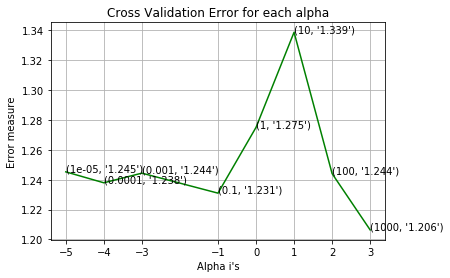

For values of best alpha =  1000 The train log loss is: 0.9304941109209992
For values of best alpha =  1000 The cross validation log loss is: 1.2063638169380666
For values of best alpha =  1000 The test log loss is: 1.1994795518732768


In [58]:
# Hyper parameter tuning
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    # Fit Naive Bayes classifier according to X, y
    clf.fit(train_x_onehotCoding, train_y)
    # We use calibratedClassifierCV to get probability values.
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    # Fit Naive Bayes classifier according to train_x_onehotCoding object.
    sig_clf.fit(train_x_onehotCoding, train_y)
    # Posterior probabilities of classification size is 532*9
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    # Append the log-loss values to cv_log_error_array size is 
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

# Plot the log-loss
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
# Function enumerate returns tuples with index value & log loss value like in this case (7 1.312)
# Here 7 is the index value & 1.312 is the log loss. It can be cross verified with the output.
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# We take that alpha which gives us lowest log-loss & train the model.
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2063638169380666
Number of missclassified point : 0.41353383458646614
------------------------------ Confusion matrix ------------------------------


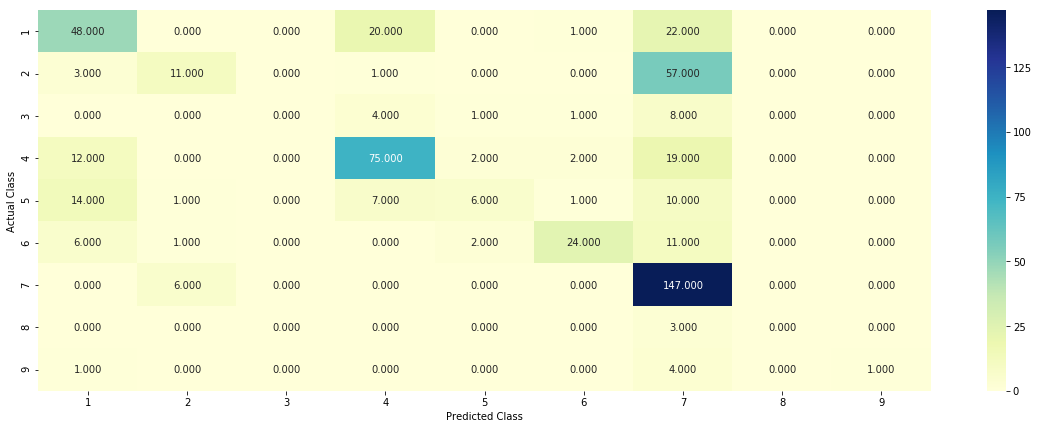

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


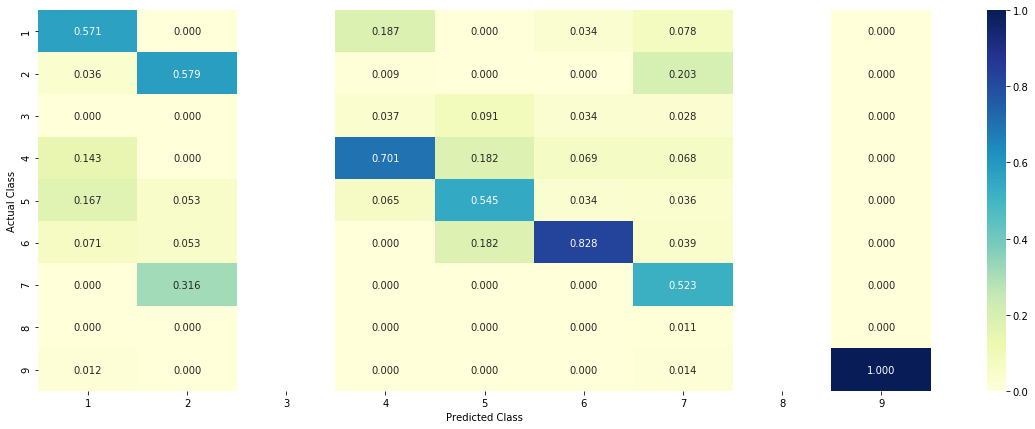

------------------------------ Recall matrix (Row sum=1) ------------------------------


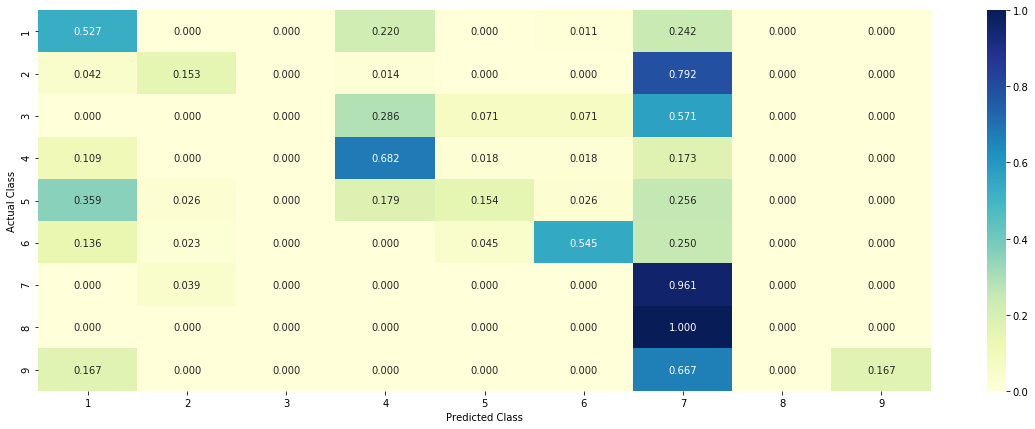

In [59]:
# Testing the model with best hyper parameters

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [60]:
# Correctly classified point
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1154 0.0455 0.0061 0.5384 0.028  0.043  0.2168 0.0046 0.0022]]
Actual Class : 4
--------------------------------------------------
8 Text feature [proteins] present in test data point [True]
9 Text feature [protein] present in test data point [True]
10 Text feature [activity] present in test data point [True]
11 Text feature [experiments] present in test data point [True]
14 Text feature [acid] present in test data point [True]
16 Text feature [function] present in test data point [True]
17 Text feature [shown] present in test data point [True]
18 Text feature [determined] present in test data point [True]
19 Text feature [described] present in test data point [True]
20 Text feature [ability] present in test data point [True]
21 Text feature [amino] present in test data point [True]
22 Text feature [indicated] present in test data point [True]
23 Text feature [loss] present in test data point [True]
31 Text feature [type] present i

In [61]:
# Incorrectly classified point
test_point_index = 148
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1185 0.1774 0.0153 0.1217 0.0525 0.0519 0.4515 0.0067 0.0045]]
Actual Class : 5
--------------------------------------------------
14 Text feature [cells] present in test data point [True]
15 Text feature [activated] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [cell] present in test data point [True]
21 Text feature [contrast] present in test data point [True]
22 Text feature [activation] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [shown] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
28 Text feature [growth] present in test data point [True]
29 Text feature [signaling] present in test data point [True]
31 Text feature [independent] present in test data point [True]
32 Text feature [treated] present in test data point [True]
33 Text feature [10] pr

#### 6.1.2 K-Nearest Neighbour Classification

for alpha = 5
Log Loss : 1.060682739643931
for alpha = 11
Log Loss : 1.0047507093420545
for alpha = 15
Log Loss : 1.0111342008775188
for alpha = 21
Log Loss : 1.0280669305695824
for alpha = 31
Log Loss : 1.0495904136996757
for alpha = 41
Log Loss : 1.0746848851850503
for alpha = 51
Log Loss : 1.0869416300804764
for alpha = 99
Log Loss : 1.113174000812265


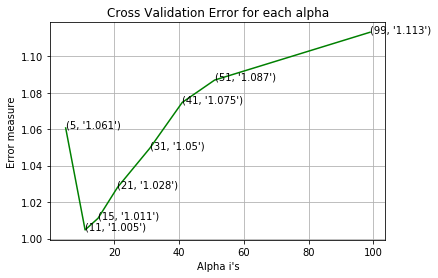

For values of best alpha =  11 The train log loss is: 0.6494949478064407
For values of best alpha =  11 The cross validation log loss is: 1.0047507093420545
For values of best alpha =  11 The test log loss is: 1.0610430327896998


In [62]:
# Hyperparameter tuning

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0047507093420545
Number of mis-classified points : 0.35714285714285715
------------------------------ Confusion matrix ------------------------------


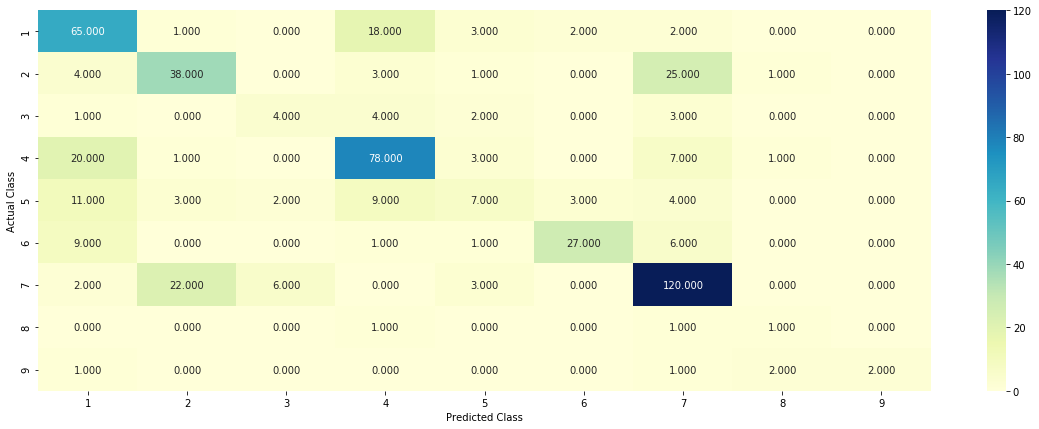

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


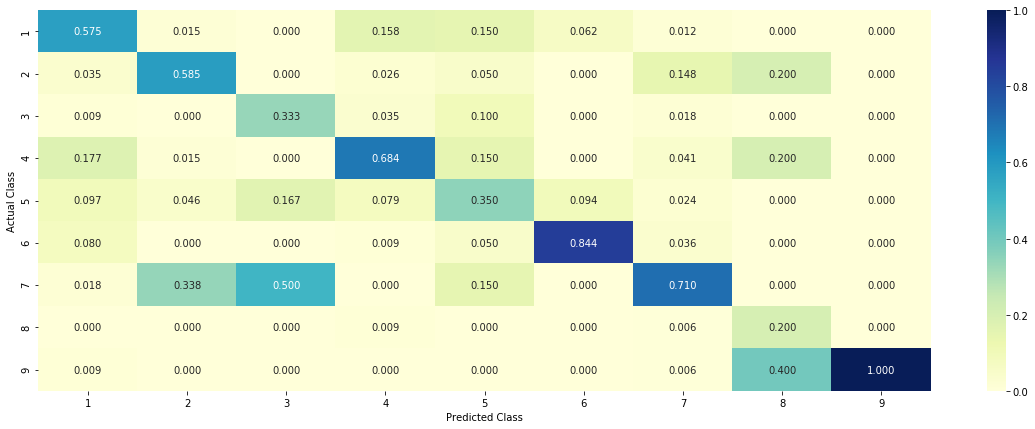

------------------------------ Recall matrix (Row sum=1) ------------------------------


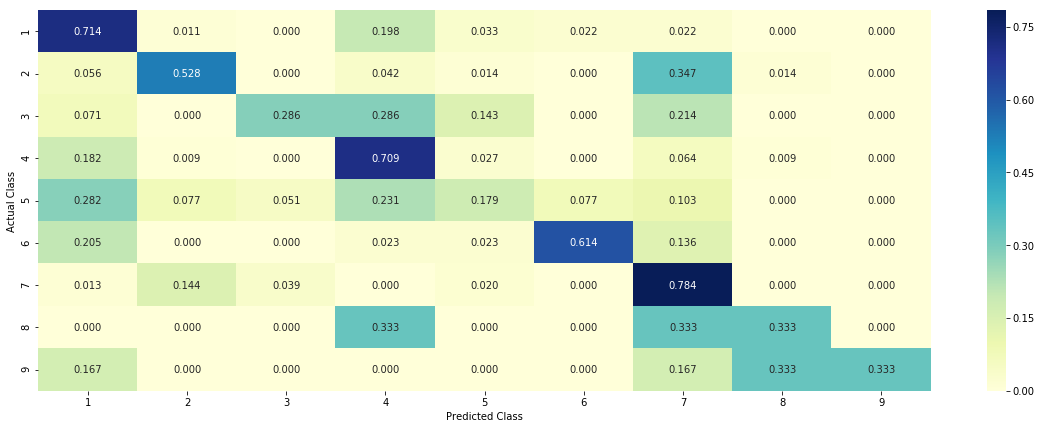

In [63]:
# Testing the model with best hyperparameters

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [64]:
# Sample query point - 1

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 3
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [6 4 4 4 1 4 4 4 1 4 4]
Fequency of nearest points : Counter({4: 8, 1: 2, 6: 1})


In [65]:
# Sample query point - 2

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [7 7 7 4 8 7 7 7 7 7 2]
Fequency of nearest points : Counter({7: 8, 4: 1, 8: 1, 2: 1})


#### 6.1.3 Logistic Regression

##### With class balancing

for alpha = 1e-06
Log Loss : 1.3813765261294126
for alpha = 1e-05
Log Loss : 1.3384006667727777
for alpha = 0.0001
Log Loss : 1.2761232315310191
for alpha = 0.001
Log Loss : 1.0699917474913634
for alpha = 0.01
Log Loss : 1.1696185103845291
for alpha = 0.1
Log Loss : 1.2784342474759616
for alpha = 1
Log Loss : 1.4591978784931272
for alpha = 10
Log Loss : 1.49380529375582
for alpha = 100
Log Loss : 1.4978389781913735


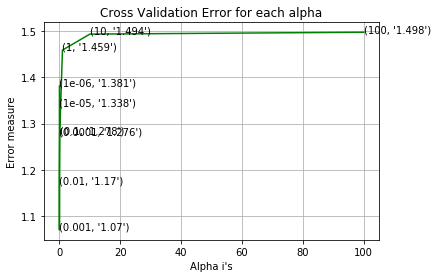

For values of best alpha =  0.001 The train log loss is: 0.6038073037345166
For values of best alpha =  0.001 The cross validation log loss is: 1.0699917474913634
For values of best alpha =  0.001 The test log loss is: 1.059317942666414


In [66]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0699917474913634
Number of mis-classified points : 0.36466165413533835
------------------------------ Confusion matrix ------------------------------


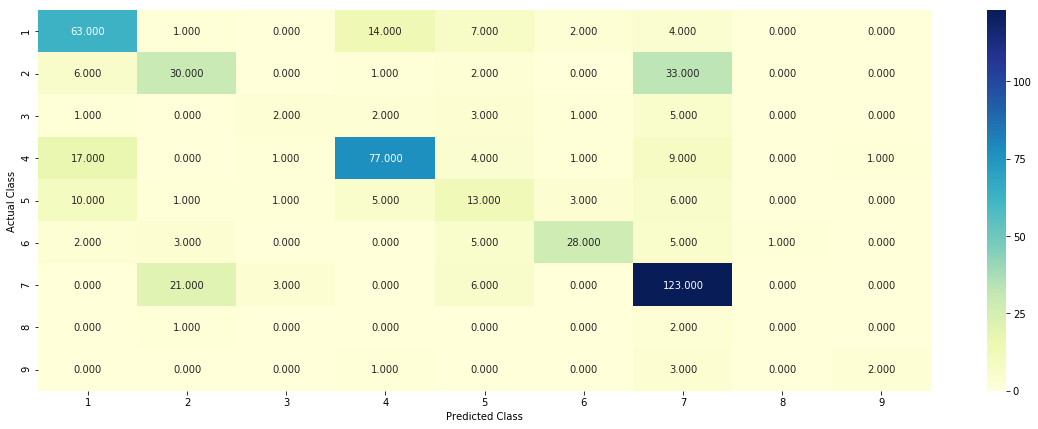

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


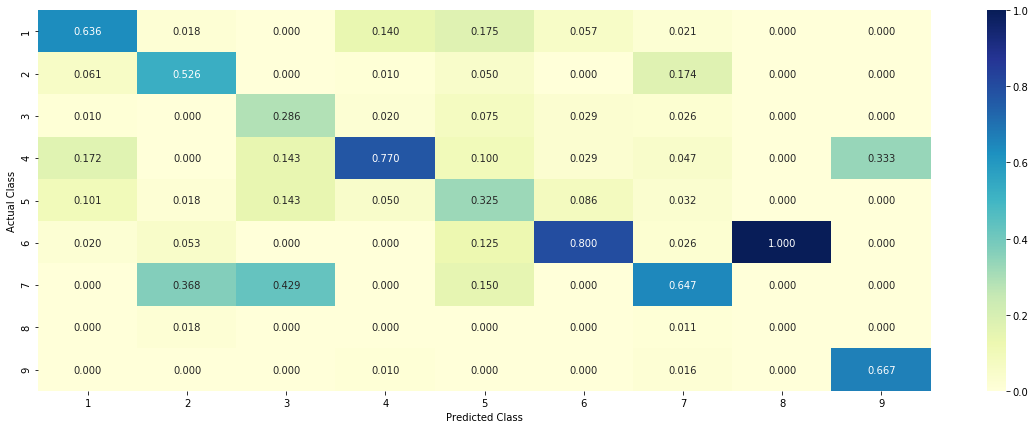

------------------------------ Recall matrix (Row sum=1) ------------------------------


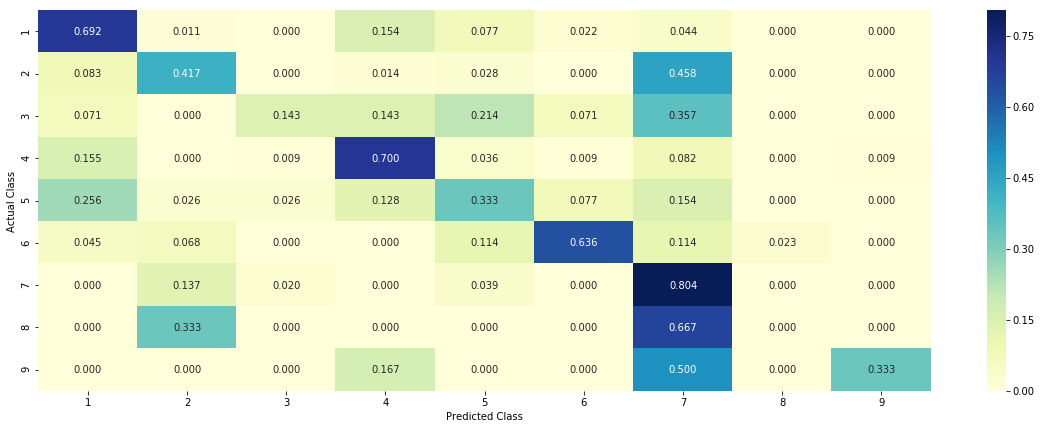

In [67]:
# Testing the model with best hyper parameters
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [505]:
# Feature importance

#def get_imp_feature_names(text, indices, removed_ind = []):
#    word_present = 0
#    tabulate_list = []
#    increasingorder_ind = 0
#    for i in indices:
#        if i < train_gene_feature_onehotCoding.shape[1]:
#            tabulte_list.append([increasingorder_ind, "Gene", "Yes"])
#        elif i< 18:
#            tabulte_list.append([increasingorder_ind,"Variation", "Yes"])
#        if ((i > 17) & (i not in removed_ind)) :
#            word = train_text_features[i]
#            yes_no = True if word in text.split() else False
#            if yes_no:
#                word_present += 1
#            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
#        increasingorder_ind += 1
#    print(word_present, "most importent features are present in our query point")
#    print("-"*50)
#    print("The features that are most importent of the ",predicted_cls[0]," class:")
#    print (tabulate(tabulate_list, headers=["Index",'Feature name', 'Present or Not']))

In [68]:
# Correctly classified point

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1766 0.0323 0.0092 0.4079 0.0235 0.2955 0.0358 0.0158 0.0034]]
Actual Class : 4
--------------------------------------------------
123 Text feature [eto] present in test data point [True]
Out of the top  200  features  1 are present in query point


In [69]:
# Incorrectly classified point

test_point_index = 148
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1399 0.201  0.0217 0.1256 0.0603 0.0483 0.3906 0.0064 0.0062]]
Actual Class : 5
--------------------------------------------------
20 Text feature [activated] present in test data point [True]
31 Text feature [constitutive] present in test data point [True]
90 Text feature [ligand] present in test data point [True]
92 Text feature [downstream] present in test data point [True]
135 Text feature [activation] present in test data point [True]
Out of the top  200  features  5 are present in query point


##### Without class balancing

for alpha = 1e-06
Log Loss : 1.3295677324116186
for alpha = 1e-05
Log Loss : 1.3396067567952885
for alpha = 0.0001
Log Loss : 1.2981194867583017
for alpha = 0.001
Log Loss : 1.114689012218534
for alpha = 0.01
Log Loss : 1.2064021734875052
for alpha = 0.1
Log Loss : 1.2850010385840307
for alpha = 1
Log Loss : 1.429008750912138


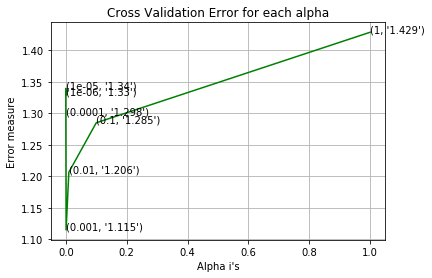

For values of best alpha =  0.001 The train log loss is: 0.6049623484116686
For values of best alpha =  0.001 The cross validation log loss is: 1.114689012218534
For values of best alpha =  0.001 The test log loss is: 1.0866069278716355


In [70]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.114689012218534
Number of mis-classified points : 0.36466165413533835
------------------------------ Confusion matrix ------------------------------


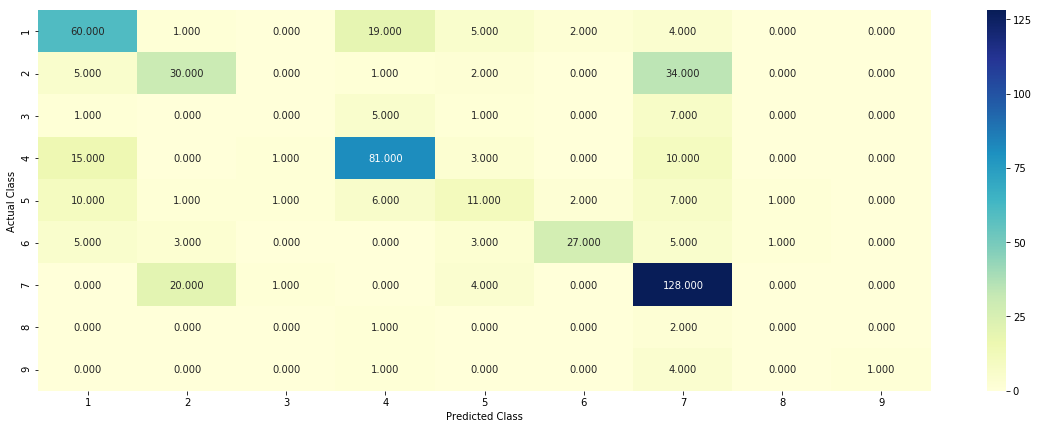

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


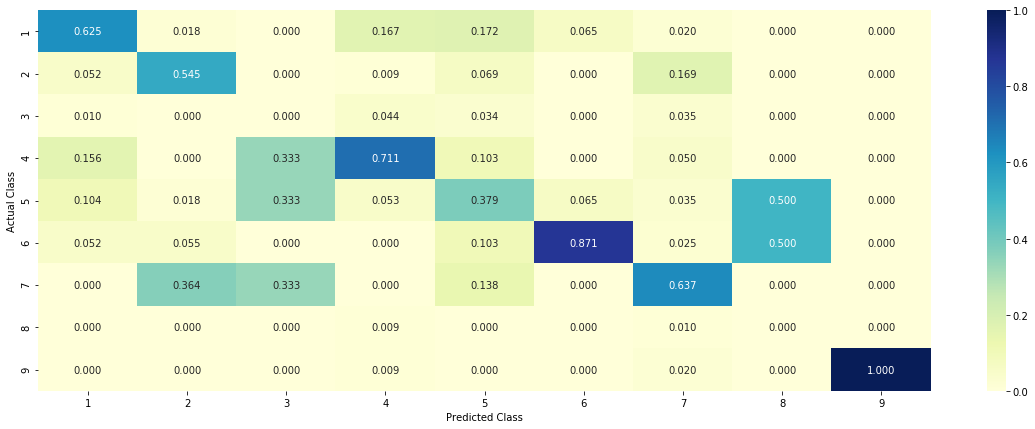

------------------------------ Recall matrix (Row sum=1) ------------------------------


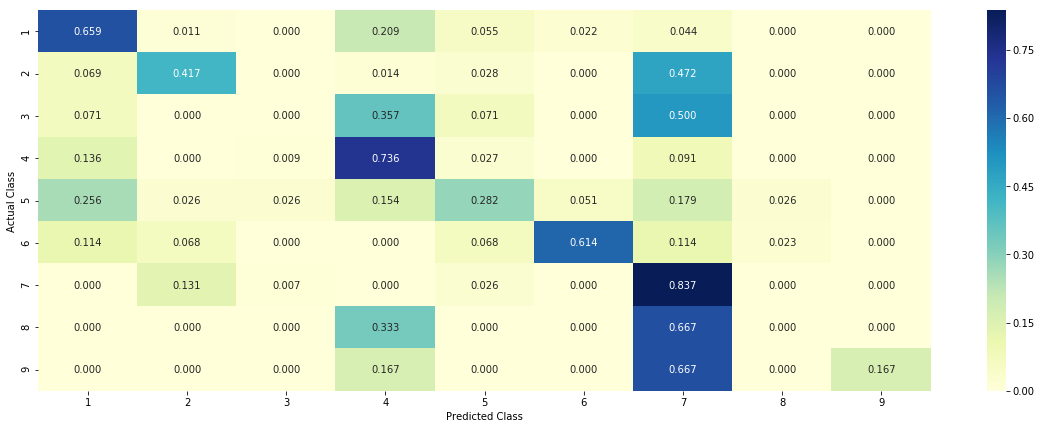

In [71]:
# Testing model with best hyper parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [72]:
# Correctly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2614 0.0349 0.0024 0.4113 0.0149 0.2017 0.0487 0.0237 0.001 ]]
Actual Class : 4
--------------------------------------------------
113 Text feature [eto] present in test data point [True]
295 Text feature [gr] present in test data point [True]
332 Text feature [hematopoiesis] present in test data point [True]
432 Text feature [preleukemic] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [73]:
# Incorrectly classfied point

test_point_index = 148
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),2))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.14 0.2  0.02 0.13 0.06 0.05 0.38 0.01 0.01]]
Actual Class : 5
--------------------------------------------------
53 Text feature [activated] present in test data point [True]
108 Text feature [constitutive] present in test data point [True]
151 Text feature [downstream] present in test data point [True]
165 Text feature [ligand] present in test data point [True]
198 Text feature [activation] present in test data point [True]
232 Text feature [expressing] present in test data point [True]
256 Text feature [activate] present in test data point [True]
276 Text feature [serum] present in test data point [True]
459 Text feature [c3h10t1] present in test data point [True]
Out of the top  500  features  9 are present in query point


#### 6.1.4 Linear SVM

for C = 1e-05
Log Loss : 1.3370472506615014
for C = 0.0001
Log Loss : 1.3397082011436492
for C = 0.001
Log Loss : 1.2388663612948472
for C = 0.01
Log Loss : 1.139100273823829
for C = 0.1
Log Loss : 1.34984795525441
for C = 1
Log Loss : 1.49898302736905
for C = 10
Log Loss : 1.4986894931934591
for C = 100
Log Loss : 1.4986895096607784


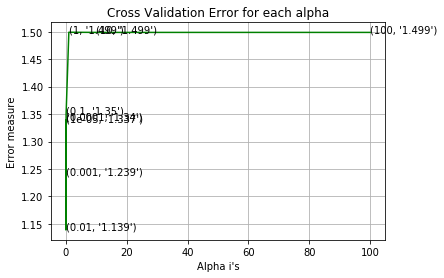

For values of best alpha =  0.01 The train log loss is: 0.7230720610947498
For values of best alpha =  0.01 The cross validation log loss is: 1.139100273823829
For values of best alpha =  0.01 The test log loss is: 1.1055737688433607


In [74]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#   clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.139100273823829
Number of mis-classified points : 0.37030075187969924
------------------------------ Confusion matrix ------------------------------


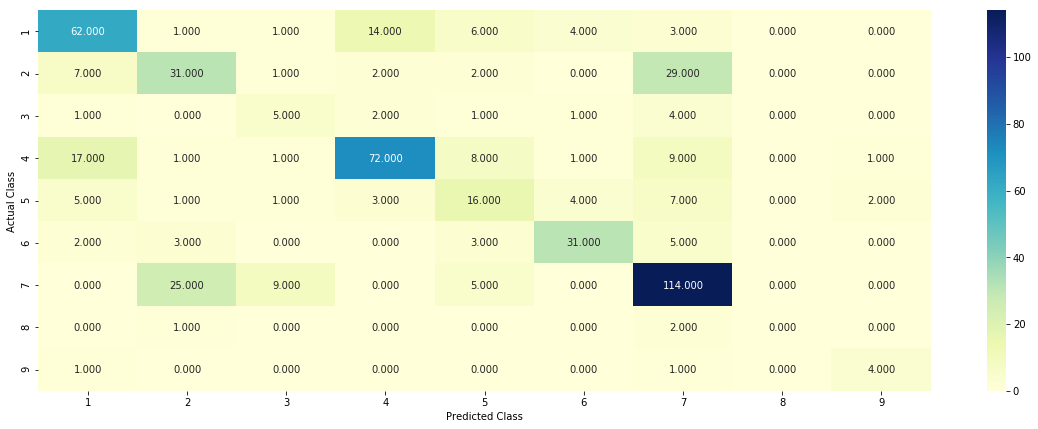

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


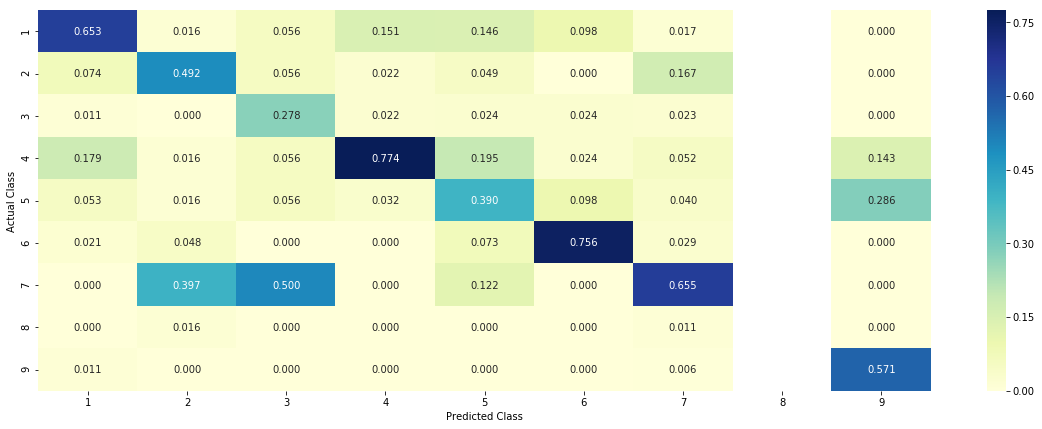

------------------------------ Recall matrix (Row sum=1) ------------------------------


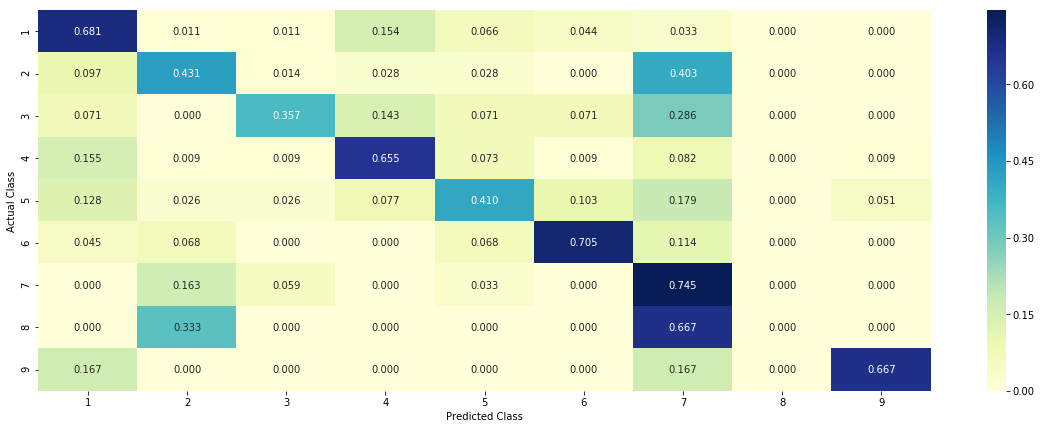

In [75]:
# Testing with best hyper parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [76]:
# Correctly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0862 0.0749 0.0183 0.4945 0.0585 0.1627 0.0735 0.0237 0.0078]]
Actual Class : 4
--------------------------------------------------
89 Text feature [nonidet] present in test data point [True]
102 Text feature [nonsense] present in test data point [True]
173 Text feature [coimmunoprecipitated] present in test data point [True]
203 Text feature [hematopoiesis] present in test data point [True]
336 Text feature [pmsf] present in test data point [True]
353 Text feature [overt] present in test data point [True]
398 Text feature [tagged] present in test data point [True]
447 Text feature [monoallelic] present in test data point [True]
484 Text feature [associates] present in test data point [True]
490 Text feature [eto] present in test data point [True]
Out of the top  500  features  10 are present in query point


In [77]:
# Incorrectly classified point

test_point_index = 148
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1809 0.186  0.0206 0.1534 0.0617 0.0495 0.3346 0.007  0.0064]]
Actual Class : 5
--------------------------------------------------
17 Text feature [activated] present in test data point [True]
39 Text feature [constitutive] present in test data point [True]
41 Text feature [activation] present in test data point [True]
49 Text feature [activate] present in test data point [True]
59 Text feature [downstream] present in test data point [True]
62 Text feature [expressing] present in test data point [True]
74 Text feature [ligand] present in test data point [True]
177 Text feature [serum] present in test data point [True]
364 Text feature [elevated] present in test data point [True]
465 Text feature [express] present in test data point [True]
Out of the top  500  features  10 are present in query point


#### 6.1.5 Random Forest Classifier

In [78]:
# Hyper parameter tuning (with one hot encoding)
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2517527018829147
for n_estimators = 100 and max depth =  10
Log Loss : 1.179012366834503
for n_estimators = 200 and max depth =  5
Log Loss : 1.2354412838076412
for n_estimators = 200 and max depth =  10
Log Loss : 1.1740084520559102
for n_estimators = 500 and max depth =  5
Log Loss : 1.2315081098177927
for n_estimators = 500 and max depth =  10
Log Loss : 1.170435822129449
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2313647646312584
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1690609411439863
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2299125693490198
for n_estimators = 2000 and max depth =  10
Log Loss : 1.165915964813413
For values of best estimator =  2000 The train log loss is: 0.6559951731914618
For values of best estimator =  2000 The cross validation log loss is: 1.1659159648134132
For values of best estimator =  2000 The test log loss is: 1.1811716679809348


Log loss : 1.1659159648134132
Number of mis-classified points : 0.4116541353383459
------------------------------ Confusion matrix ------------------------------


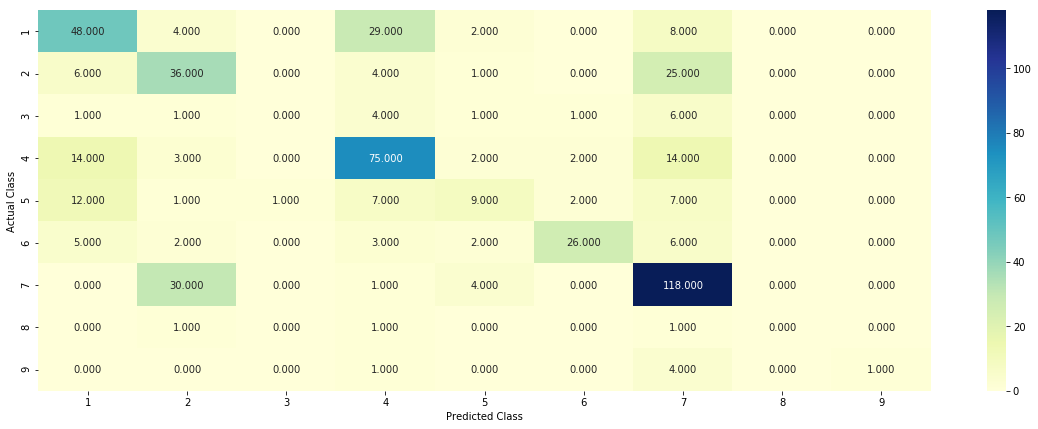

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


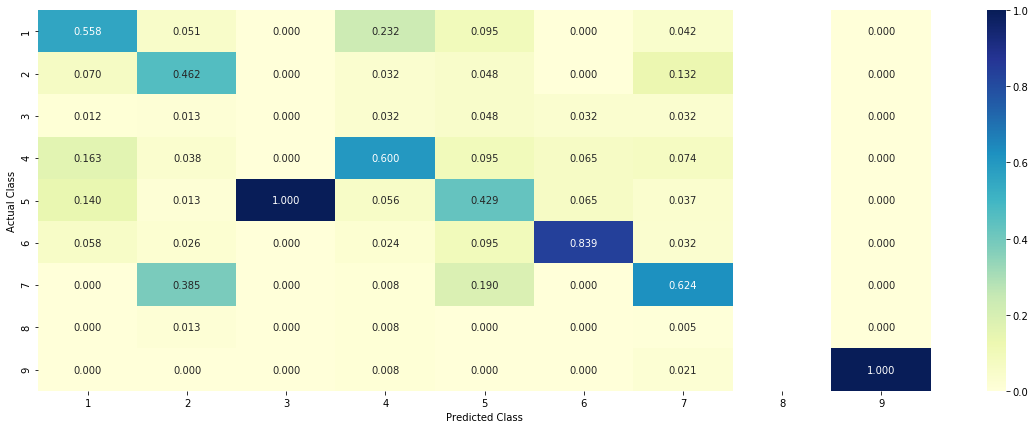

------------------------------ Recall matrix (Row sum=1) ------------------------------


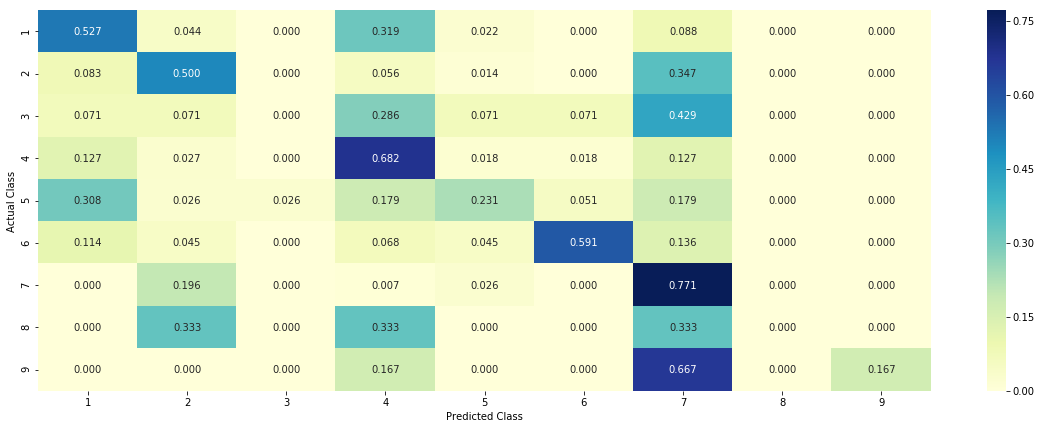

In [79]:
# Testing model with best hyper parameters (One Hot Encoding)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y,clf)

In [80]:
# Incorrectly classified point

# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 148
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1513 0.1761 0.0245 0.1534 0.0616 0.0582 0.358  0.009  0.0079]]
Actual Class : 5
--------------------------------------------------
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [activated] present in test data point [True]
5 Text feature [activation] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
9 Text feature [missense] present in test data point [True]
10 Text feature [constitutive] present in test data point [True]
11 Text feature [loss] present in test data point [True]
12 Text feature [function] present in test data point [True]
14 Text feature [signaling] present in test data point [True]
16 Text feature [suppressor] present in test data point [True]
18 Text feature [receptor] present in test data point [True]
20 Text feature [therapy] present in test data point [True]
25 Text feature [therapeutic] present in test data point [True]
26 Text feature

In [81]:
# Correctly classified point

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.074  0.149  0.0199 0.0713 0.0464 0.041  0.5855 0.0071 0.0058]]
Actuall Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
3 Text feature [activated] present in test data point [True]
4 Text feature [tyrosine] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
10 Text feature [constitutive] present in test data point [True]
11 Text feature [loss] present in test data point [True]
12 Text feature [function] present in test data point [True]
13 Text feature [oncogenic] present in test data point [True]
14 Text feature [signaling] present in test data point [True]
18 Text featur

In [82]:
# Hyper parameter tuning (with response coding)

alpha = [10,50,100,200,500,800,1000]
max_depth = [2,3,5,7,9,11]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0306619501398195
for n_estimators = 10 and max depth =  3
Log Loss : 1.848239007883274
for n_estimators = 10 and max depth =  5
Log Loss : 1.7375000562931675
for n_estimators = 10 and max depth =  7
Log Loss : 1.387555098868967
for n_estimators = 10 and max depth =  9
Log Loss : 1.9737123159750576
for n_estimators = 10 and max depth =  11
Log Loss : 2.0905586500283597
for n_estimators = 50 and max depth =  2
Log Loss : 1.8300888259836683
for n_estimators = 50 and max depth =  3
Log Loss : 1.5393782786070977
for n_estimators = 50 and max depth =  5
Log Loss : 1.3597729862642758
for n_estimators = 50 and max depth =  7
Log Loss : 1.3668978396192564
for n_estimators = 50 and max depth =  9
Log Loss : 1.6772786653656875
for n_estimators = 50 and max depth =  11
Log Loss : 1.8514586432047302
for n_estimators = 100 and max depth =  2
Log Loss : 1.6379443360327075
for n_estimators = 100 and max depth =  3
Log Loss : 1.5437224547023625
for 

Log loss : 1.3632266620397666
Number of mis-classified points : 0.46616541353383456
------------------------------ Confusion matrix ------------------------------


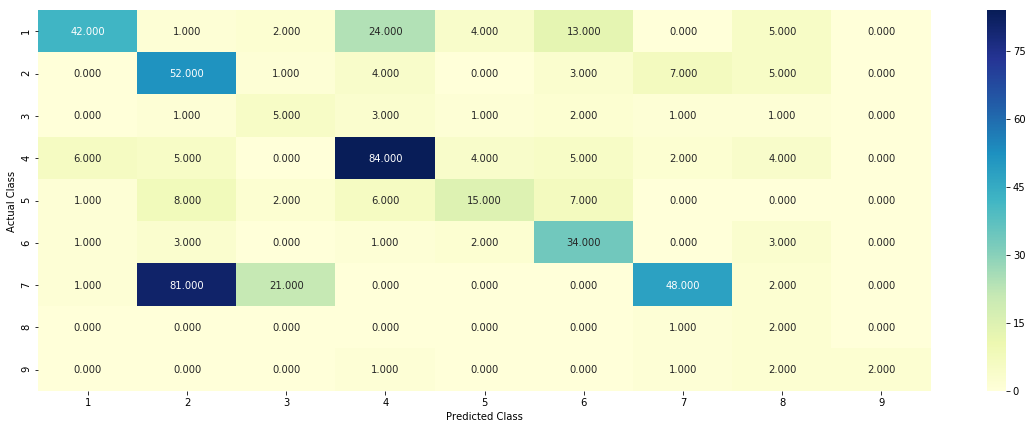

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


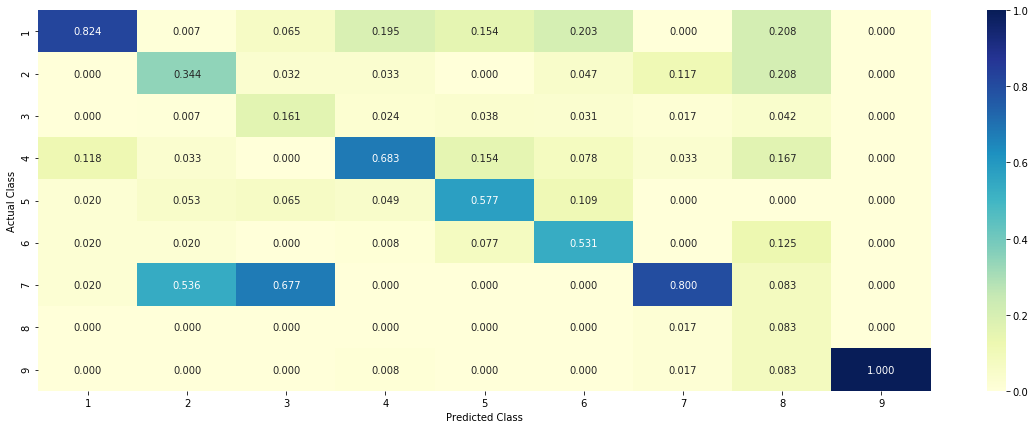

------------------------------ Recall matrix (Row sum=1) ------------------------------


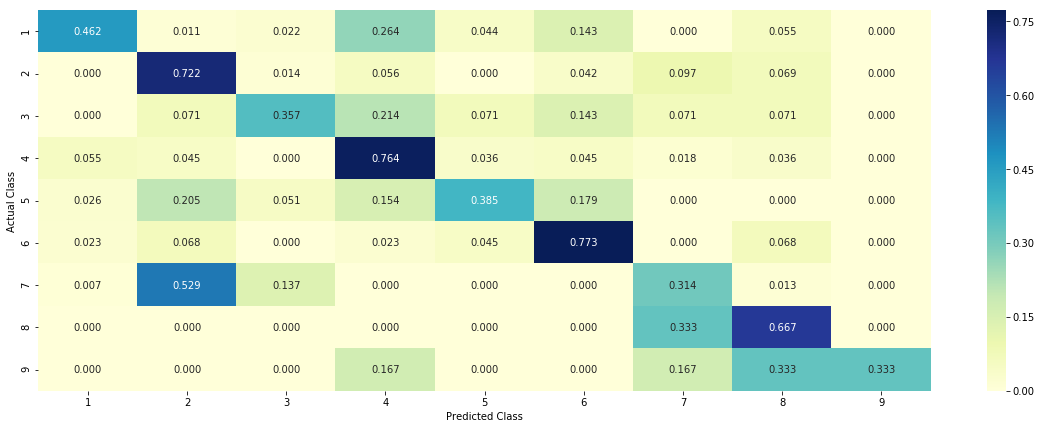

In [83]:
# Testing model with best hyper parameters

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [84]:
# Correctly classified point

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1344 0.0211 0.1154 0.5175 0.0338 0.0939 0.0144 0.0425 0.0269]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [85]:
# Inorrectly classified point

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0197 0.2814 0.252  0.0352 0.0305 0.0602 0.2417 0.058  0.0213]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


#### 6.1.6 Stacking up the models

In [86]:
# Hyper parameter tuning

from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.04
Support vector machines : Log Loss: 1.50
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.037
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.503
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.110
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.202
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.410


Log loss (train) on the stacking classifier : 0.646318715819048
Log loss (CV) on the stacking classifier : 1.1098523027600293
Log loss (test) on the stacking classifier : 1.1338161959236759
Number of missclassified point : 0.37593984962406013
------------------------------ Confusion matrix ------------------------------


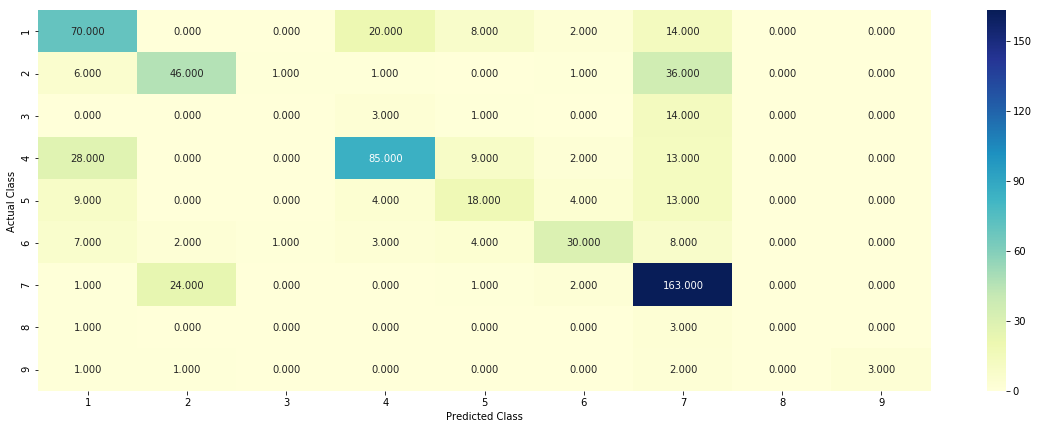

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


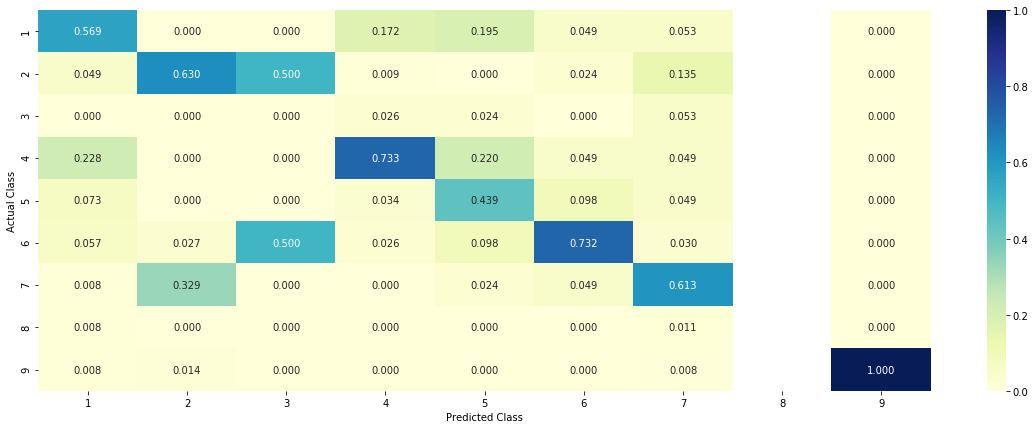

------------------------------ Recall matrix (Row sum=1) ------------------------------


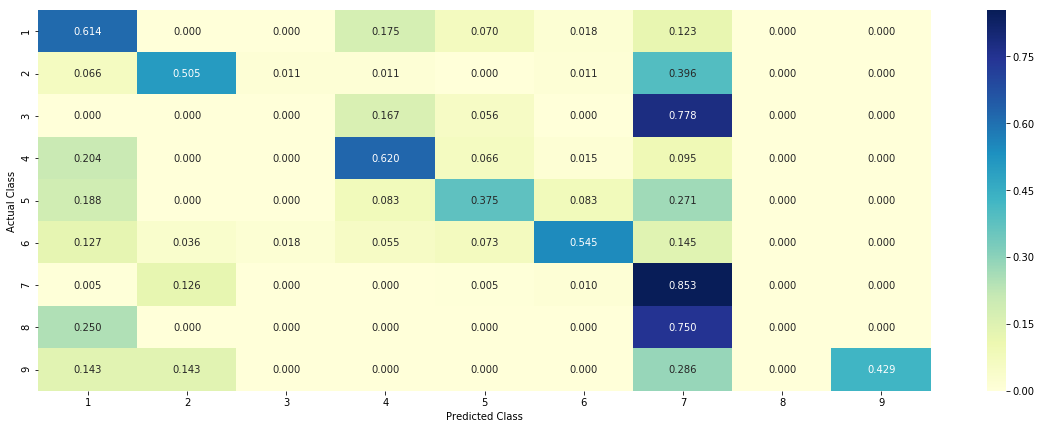

In [87]:
# Testing the model with best parameters

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, predict_y=sclf.predict(test_x_onehotCoding))

#### 6.1.7 Maximum voting classifier

Log loss (train) on the VotingClassifier : 0.8779043089798539
Log loss (CV) on the VotingClassifier : 1.136134838316289
Log loss (test) on the VotingClassifier : 1.1561893898966242
Number of missclassified point : 0.38345864661654133
------------------------------ Confusion matrix ------------------------------


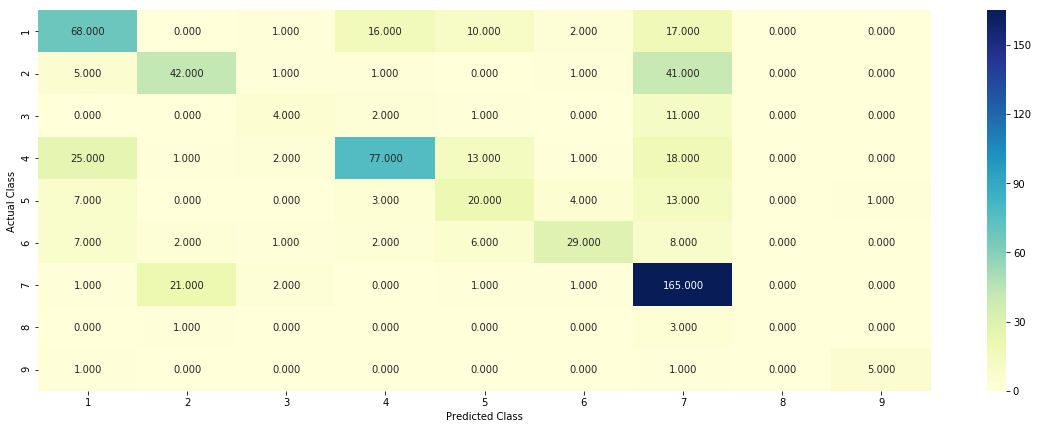

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


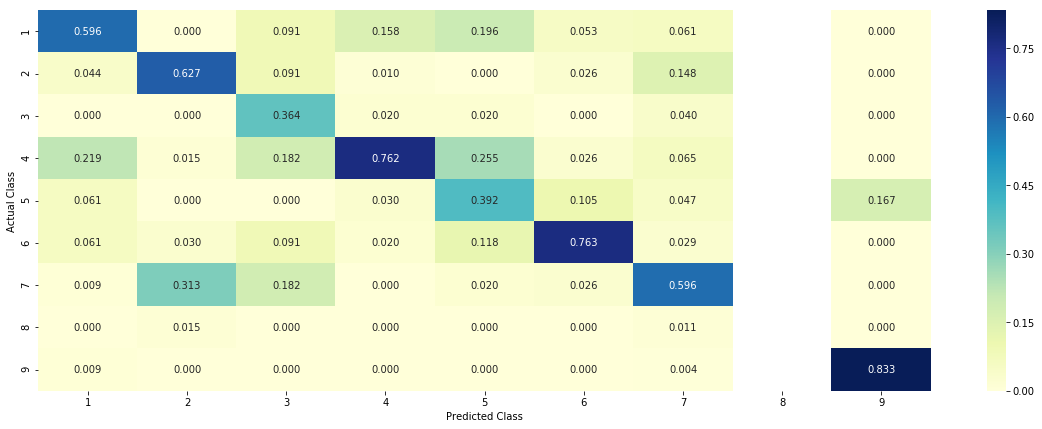

------------------------------ Recall matrix (Row sum=1) ------------------------------


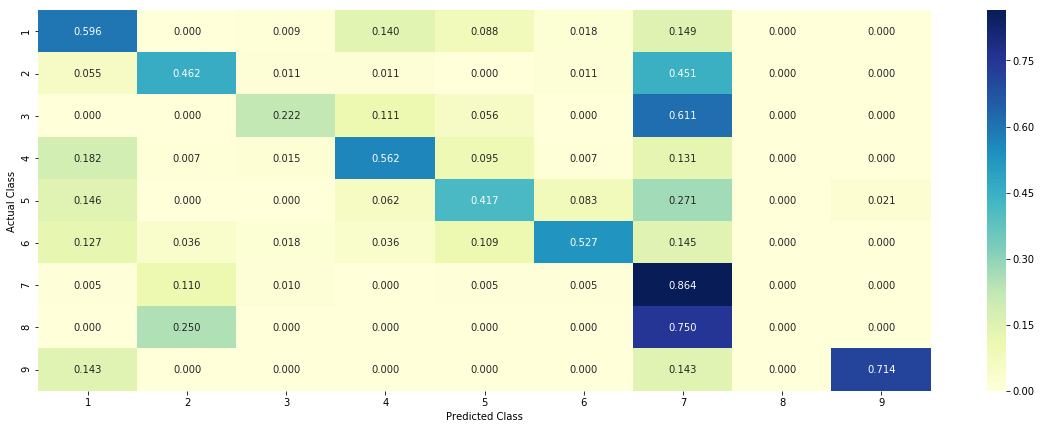

In [88]:
# Maximum voting classifier

from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, predict_y=vclf.predict(test_x_onehotCoding))

#### 7. Summary & Conclusion

In [89]:
# Summary of models
print()
print("*"*20, "Summary of models-[Performance metric:Log-loss]", "*"*28)

x = PrettyTable()
x.title = "*** Summary of models *** [Performance metric:Log-loss]"
x.field_names=["Model Name","Train","CV","Test","% Misclassified Points"]
x.add_row(["Naive Bayes","0.93","1.2","1.19","41.3"])
x.add_row(["KNN","0.64","1.0","1.06","35.7"])
x.add_row(["Logistic Regression With Class balancing","0.6","1.06","1.05","36.4"])
x.add_row(["Logistic Regression Without Class balancing","0.6","1.11","1.08","36.4"])
x.add_row(["Linear SVM","0.72","1.13","1.1","37"])
x.add_row(["Random Forest Classifier With One hot Encoding","0.65","1.16","1.18","41.1"])
x.add_row(["Random Forest Classifier With Response Coding","0.05","1.36","1.39","46.6"])
x.add_row(["Stack Models:LR+NB+SVM","0.64","1.1","1.13","37.6"])
x.add_row(["Maximum Voting classifier","0.87","1.13","1.15","38.3"])

print(x)
print()


******************** Summary of models-[Performance metric:Log-loss] ****************************
+------------------------------------------------+-------+------+------+------------------------+
|                   Model Name                   | Train |  CV  | Test | % Misclassified Points |
+------------------------------------------------+-------+------+------+------------------------+
|                  Naive Bayes                   |  0.93 | 1.2  | 1.19 |          41.3          |
|                      KNN                       |  0.64 | 1.0  | 1.06 |          35.7          |
|    Logistic Regression With Class balancing    |  0.6  | 1.06 | 1.05 |          36.4          |
|  Logistic Regression Without Class balancing   |  0.6  | 1.11 | 1.08 |          36.4          |
|                   Linear SVM                   |  0.72 | 1.13 | 1.1  |           37           |
| Random Forest Classifier With One hot Encoding |  0.65 | 1.16 | 1.18 |          41.1          |
| Random Forest Cla

#### Summary

Summarization of above table :

1) From the above table we have KNN, Logistic regression(Class Balancing), Logistic regression (without balancing)
models having log-loss very close to 1. 
So, when we compare these three models: Logistic regression(class balancing) is a better choice of model because:

a) It can handle large dimension of data.
b) It can provide feature importance which is very important.
Also when we consider % of misclassified points, Logistic regression is very close to what KNN model offers us.

2) Random Forest (with response coding) overfits our CV & test by a huge margin. Also it has highest percentage of misclassified 
points

#### Conclusion: 

We can choose Logistic Regression(class balancing) as our go to model in deployment stage.
